# Computing the energy density of the Glasma in the MV model

In this notebook we compute the energy density of the Glasma in the MV model and compare the result to Tuomas Lappi's value from 2006 (see [**arXiv:hep-ph/0606207**](https://arxiv.org/abs/hep-ph/0606207)). By reproducing the same energy density we can be sure that our code works correctly. At $\tau_0 = 1.0 / g^2 \mu$ we obtain $\varepsilon(\tau_0) = 0.262 (g^2 \mu)^4 / g^2 $ which translates to $\varepsilon(\tau_0) = 136 \, \mathrm{GeV} / \mathrm{fm}^3$ for $g^2 \mu = 2.0 \, \mathrm{GeV}$ and $\varepsilon(\tau_0) = 691 \, \mathrm{GeV} / \mathrm{fm}^3$ for $g^2 \mu = 3.0 \, \mathrm{GeV}$. The numbers from [**arXiv:hep-ph/0606207**](https://arxiv.org/abs/hep-ph/0606207) are $130 \, \mathrm{GeV} / \mathrm{fm}^3$ and $700 \, \mathrm{GeV} / \mathrm{fm}^3$. Close enough.

In [2]:
# Set environment variables 
import os
os.environ["MY_NUMBA_TARGET"] = "numba"
os.environ["GAUGE_GROUP"] = "su2"
os.environ["PRECISION"] = "double"

# Import curraun and other packages
import sys
sys.path.append('..')

import curraun.core as core
import curraun.mv as mv
from curraun.energy import Energy
from curraun.lyapunov_10092025 import Lyapunov				# Edited 10.09.2025
#from curraun.lyapunov import Lyapunov				# Edited 10.09.2025

import curraun.initial as initial
initial.DEBUG = False

from curraun.numba_target import use_cuda, use_numba
if use_cuda:
    from numba import cuda

import numpy as np
import pickle
from tqdm import tqdm
import copy

import datetime
from datetime import datetime                                           # Pooja

import matplotlib.pyplot as plt
from matplotlib import rc

import pandas as pd


#from numba import set_num_threads
#set_num_threads(int(2))


# ======================= VERIFICATION LINES FOR NO. OF THREADS =======================
from numba import get_num_threads
print("\nNumba threads:", get_num_threads())              # Should output the number given here: os.environ["NUMBA_NUM_THREADS"] = "4" 
print("\n")

# ????????????????????????????????? Doesn't work ????????????????????????????????? 
#print("NumPy max threads:", np.__config__.show())  # Should reflect your limit
#print("NumPy max threads:", np.__config__.get_info("max_threads"))  # Should reflect your limit     # The error occurs because np.__config__.get_info() doesn't exist in newer NumPy versions. 

# New way to check NumPy threading (works for all NumPy versions)
#try:
#    from threadpoolctl import threadpool_info
#    for lib in threadpool_info():
#        if lib['internal_api'] in ('openmp', 'mkl', 'openblas'):
#            print(f"{lib['internal_api'].upper()} threads:", lib['num_threads'])
#except ImportError:
#    print("Install threadpoolctl for detailed thread info: pip install threadpoolctl")
#    print("NumPy thread config:", np.__config__.show())

# =====================================================================================



# We compute everything for g^2 \mu = 1 GeV and then rescale the results.
hbarc = 0.197326                                                    # define hbar * c in units of GeV * fm
g2mu = 1.0                                                          # g²mu [GeV]
g = 2.0                                                             # Coupling constant [Dimensionless]
mu = g2mu / g ** 2                                                  # MV model parameter [GeV]
m = 0.00001                                                         # No infrared regulation, except global charge neutrality [????????]

RA = 67.7 / (g2mu / hbarc)                                          # Radius of the nucleus [fm]
F = np.pi * RA ** 2                                                 # Transverse area of the nucleus [fm^2]
L = np.sqrt(F)                                                      # Length of the simulation box [fm]
#L = 16.0

N_LatticePoints = 128                                                # Number of lattice points [Dimensionless]     
delta_x = L / N_LatticePoints                                       # Lattice Spacing [fm]     

DTS = 16
taumax = 100.0                                                     # [Dimensionless]       
                                                                    # 30.0 for N = 4          # 1000.0                                                                                 
tau_max = taumax * (hbarc / g2mu)                                      # Maximum proper time    # 10.0 * hbarc / g2mu      [fm]  


N_events = 2                                                       # Number of events [Dimensionless]


GeV_to_latt = delta_x/hbarc                                         # GeV to lattice units [GeV⁻¹]
fm_to_latt  = 1.0/delta_x                                           # fm to lattice units  [fm⁻¹]

fmInverse_to_latt = delta_x                                         # fm⁻¹ to lattice units [fm]
GeVInverse_to_latt = hbarc/delta_x                                  # GeV⁻¹ to lattice units [GeV]

latt_to_GeV = hbarc/delta_x                                         # lattice units to GeV [GeV]
latt_to_fm  = delta_x                                               # lattice units to fm  [fm]

tau_max_Latt = tau_max*fm_to_latt

max_timesteps = int(tau_max/ delta_x) * DTS                                        # int: Keeps the value as integer



Option_noise_type = 3                                                   # 0: No noise
                                                                        # 1: Exponential noise
                                                                        # 2: Power-law noise
                                                                        # 3: Independent noise (theta function)

Lypnv_alpha = 0.0001                                                    # [Dimensionless]



""""""""""""""""""""""""""""""""" Paramters for Exponential and Power-law noise """""""""""""""""""""""""""""""""""""""""""""""
Lypnv_noise_scale   = 1.0                                           # Scaling factor for the noise  [Dimensionless]  
Lypnv_noise_phy     = Lypnv_noise_scale * g2mu                      # Noise for FFT                 [GeV]         
Lypnv_noise_latt    = Lypnv_noise_phy * GeV_to_latt                 # Noise for FFT                 [lattice units]   
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

"""""""""""""""""""""""""""""""""""" Paramters for Independent noise (Theta function) """""""""""""""""""""""""""""""""""""""""""""""""""
Lypnv_K_scale = 0.5

Lypnv_dk_phy = 2.0 * np.pi / L                                                                  # Lattice momentum spacing  [fm^-1]
Lypnv_dk_shell_phy = 2.0 * Lypnv_dk_phy                                                         # Shell thickness           [fm^-1]
Lypnv_K_centre_phy = Lypnv_K_scale * Lypnv_dk_shell_phy                                         # Centre of the shell       [fm^-1]

Lypnv_dk_latt        =  Lypnv_dk_phy * fmInverse_to_latt                                       # Lattice momentum spacing   [lattice units] [Dimensionless]
Lypnv_dk_shell_latt  =  Lypnv_dk_shell_phy * fmInverse_to_latt                                 # Shell thickness            [lattice units] [Dimensionless]
Lypnv_K_centre_latt  =  Lypnv_K_centre_phy * fmInverse_to_latt                                 # Centre of the shell        [lattice units] [Dimensionless]
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""



""""""""""""""""""""""""""""""""""""""""""""""""""" Noise Type string """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
if Option_noise_type == 0:
    Noise_type = "No noise"
    noise_type_str = "None"
elif Option_noise_type == 1:
    Noise_type = "Exponential noise"
    noise_type_str = "EXP"
elif Option_noise_type == 2:
    Noise_type = "Power-law noise"
    noise_type_str = "PL"
elif Option_noise_type == 3:
    Noise_type = "Independent noise, Theta function"
    noise_type_str = "THETA"
else:
    print("\nError: Option_noise_type not recognized")
    sys.exit(1)
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""



# Formatting strings for filenames
noise_type_str = f"{noise_type_str}"
alpha_str      =  f"{Lypnv_alpha:.6f}".rstrip('0').rstrip('.')
mnoise_str     =  f"{Lypnv_noise_scale:.1f}" 
K_str          =  f"{Lypnv_K_scale:.1f}"


print("Noise type string  = ", noise_type_str)
print("alpha string       = ", alpha_str)
print("mnoise string      = ", mnoise_str)
print("K string           = ", K_str)
print("\n")
print("Lypnv_K_scale       = ", Lypnv_K_scale, "\n")

print("Lypnv_K_centre_phy  = ", Lypnv_K_centre_phy, "fm^-1")
print("Lypnv_K_centre_latt = ", Lypnv_K_centre_latt, "lattice units", "\n")

print("Lypnv_dk_phy        = ", Lypnv_dk_phy, "fm^-1")
print("Lypnv_dk_latt       = ", Lypnv_dk_latt, "lattice units", "\n")
"""
print("\n")

print("No. of events  =", N_events, "\n")   

print("hbarc                = ", hbarc, "GeV-fm", "\n")
print("g2mu                 = ", g2mu, "GeV")
print("Coupling constant, g = ", g)
print("mu                   = ", mu, "GeV")
print("m                    = ", m, "GeV", "\n")

print("Radius of the nucleus, RA          = ", RA, "fm")
print("Transverse area of the nucleus, F  = ", F, "fm^2", "\n")

print("Length of the simulation box, L    = ", L, "fm")
print("Number of lattice points, N        = ", N_LatticePoints)
print("Lattice spacing, delta_x           = ", delta_x, "fm", "\n")
print("g2mu.a                             = ", g2mu*delta_x, "GeV-fm", "\n")

print("taumax                       = ", taumax)
print("Maximum proper time, tau_max = ", tau_max, "fm/c or fm", "\n")

print("Maximum proper time (in dimensionless units), tau_max_Latt  = ", tau_max_Latt, "lattice units", "\n")
print("Number of time steps per transverse spacing, DTS  = ", DTS)
print("Total No. of time steps for full Glasma simulation, max_timesteps     = ", max_timesteps, "\n")
print("1/DTS  = ", 1/DTS)

print("GeV to lattice units = ", GeV_to_latt)
print("fm to lattice units  = ", fm_to_latt, "\n")

print("lattice units to GeV = ", latt_to_GeV)
print("lattice units to fm  = ", latt_to_fm, "\n")

print("GeV^-1 to lattice units  = ", GeVInverse_to_latt)
print("fm^-1  to lattice units  = ", fmInverse_to_latt, "\n")



print("\n====================================================================")
print("============= PARAMETERS USED FOR LYPANUNOV EXPONENTS: ============= ") 

print("No. of events  = ", N_events, "\n")   
print("Number of lattice points, N = ", N_LatticePoints, "\n") 
print("taumax                      = ", taumax, "\n") 
print("g2mu                        = ", g2mu, "GeV", "\n") 

print("Option_noise_type   = ", Option_noise_type, "\n")
print("Noise type          = ", Noise_type, "\n")    

print("Lypnv_alpha         = ", Lypnv_alpha, "\n")

print("Lypnv_noise_scale   = ", Lypnv_noise_scale)
print("g2mu                = ", g2mu, "GeV")
print("Lypnv_noise_phy     = ", Lypnv_noise_phy, "GeV")                                 
print("Lypnv_noise_latt    = ", Lypnv_noise_latt, "lattice units", "\n\n")

print("Lypnv_K_scale       = ", Lypnv_K_scale, "\n")

print("Lypnv_K_centre_phy  = ", Lypnv_K_centre_phy, "fm^-1")
print("Lypnv_K_centre_latt = ", Lypnv_K_centre_latt, "lattice units", "\n")

print("Lypnv_dk_phy        = ", Lypnv_dk_phy, "fm^-1")
print("Lypnv_dk_latt       = ", Lypnv_dk_latt, "lattice units", "\n")

print("Lypnv_dk_shell_phy  = ", Lypnv_dk_shell_phy, "fm^-1")
print("Lypnv_dk_shell_latt = ", Lypnv_dk_shell_latt, "lattice units", "\n")


print("Noise type string  = ", noise_type_str)
print("alpha string       = ", alpha_str)
print("mnoise string      = ", mnoise_str)
print("K string           = ", K_str)
print("\n")


print("====================================================================", "\n")
"""



p_lappi = {    
    'L':    L,                                                      # transverse size [fm]

    'N':    N_LatticePoints,                                        # lattice points             # # Pooja

    'DTS':  DTS,                                                      # time steps per transverse spacing
    'TMAX': tau_max,                                                # max. proper time (tau) [fm/c]

    'G':    g,                                                      # YM coupling constant
    'MU':   mu,                                                     # MV model parameter [GeV]
    'M':    m,                                                      # IR regulator [GeV]
    'UV':   100000.0,                                               # UV regulator [GeV]
    'NS':   1,                                                      # number of color sheets

    'NE':   N_events,                                               # number of events



    'Ly_Option_Noise_type': Option_noise_type,                                                                             


    'Ly_alpha': Lypnv_alpha, 

    'Ly_M_noise_phy' : Lypnv_noise_phy,                                     # Noise for FFT [GeV]
    'Ly_K_centre_phy': Lypnv_K_centre_phy,                                  # Centre of the shell [fm^-1]
    'Ly_dk_shell_phy': Lypnv_dk_shell_phy,                                  # Shell thickness [fm^-1]

    'Ly_M_noise_latt' : Lypnv_noise_latt,                                   # Noise for FFT [lattice units]
    'Ly_K_centre_latt': Lypnv_K_centre_latt,                                # Centre of the shell [lattice units]
    'Ly_dk_shell_latt': Lypnv_dk_shell_latt,                                # Shell thickness
}


#print("INT(taumax*N/L) = ", int (p_lappi["TMAX"]*p_lappi["N"]/p_lappi["L"])    )                                                                 # Pooja
#print("INT(taumax*N/L) * DTS = ", int (p_lappi["TMAX"]*p_lappi["N"]/p_lappi["L"]) * p_lappi["DTS"], "\n")


start_time = datetime.now()
print("\nHello, this cell is run at", start_time)





Numba threads: 8


Noise type string  =  THETA
alpha string       =  0.0001
mnoise string      =  1.0
K string           =  0.5


Lypnv_K_scale       =  0.5 

Lypnv_K_centre_phy  =  0.2653578568362277 fm^-1
Lypnv_K_centre_latt =  0.049087385212340524 lattice units 

Lypnv_dk_phy        =  0.2653578568362277 fm^-1
Lypnv_dk_latt       =  0.049087385212340524 lattice units 


Hello, this cell is run at 2025-09-12 15:58:12.378941


In [ ]:
def compute(p):    
    # output dictionary
    output = {}

    output["energy"], output["pL"] , output["pT"]  = [], [], []
    output["EL"], output["BL"], output["ET"], output["BT"] = [], [], [], []

    output["energyp"], output["pLp"] , output["pTp"]  = [], [], []
    output["ELp"], output["BLp"], output["ETp"], output["BTp"] = [], [], [], []

    output["ratio_dif"]          = []
    output["ratio_dif_variance"] = []
    output["ratio_dif_std"]      = []
    output["ratio_dif_error"]    = []

    output["ratio_difalpha2"]          = []
    output["ratio_difalpha2_variance"] = []
    output["ratio_difalpha2_std"]      = []
    output["ratio_difalpha2_error"]    = []

    

    #print("output[ratio_dif] = ", output["ratio_dif"])

    
    # derived parameters
    a = p['L'] / p['N']
    E0 = p['N'] / p['L'] * hbarc                                        # E0 = Latt_to_GeV = [GeV] 
    DT = 1.0 / p['DTS']
    maxt = int(p['TMAX'] / a) * p['DTS']                                # int: Keeps the value as integer  #maximum_time_ste
    
    """

    """

    print("a  (in fm) = ", a)
    print("E0  (in GeV) = ", E0)
    print("DT  (= 1/ DTS) = ", DT)
    print("maxt  (= INT (  TMAX/a *DTS) ) = ", maxt)


    start_t = 1
    
    # event loop
    for e in range(p['NE']):
        #print("Simulating event {} of {}".format(e+1, p['NE']))            # Commented by Pooja
        print("\nSimulating event {} of {}".format(e+1, p['NE']))           # Added by Pooja


        # initialization
        s = core.Simulation(p['N'], DT, p['G'])
        va = mv.wilson(s,    mu=p['MU'] / E0,      m=p['M'] / E0,    uv=p['UV'] / E0,   num_sheets=p['NS'])
        vb = mv.wilson(s,    mu=p['MU'] / E0,      m=p['M'] / E0,    uv=p['UV'] / E0,   num_sheets=p['NS'])
        initial.init(s, va, vb)

        """
        print("va = ", va)
        print("vb = ", vb)
        print("mu=p['MU'] / E0" ,  p['MU'] / E0)
        print("m=p['M'] / E0"   ,  p['M'] / E0)
        print("uv=p['UV'] / E0" ,  p['UV'] / E0)
        print("p['NS']", p['NS'])
        """

        en = Energy(s)                                              # initialize energy computation

        

        # ************************* Lyapunov Exponents  *************************
        sprime = copy.deepcopy(s)                                   # copy of s        
        enp = Energy(sprime)                                        # ed for sprime        
        ly = Lyapunov(s, sprime)                                    # initialize Lyapunov computation        
        
        alpha     =  p["Ly_alpha"]        
        m_noise   =  p["Ly_M_noise_latt"]                                       # Added 23.04.2025
        K_centre  =  p["Ly_K_centre_latt"]                                      # Added 10.09.2025
        dk        =  p["Ly_dk_shell_latt"]                                      # Added 10.09.2025

        
        print("m_noise        =", m_noise)                  
        print("alpha          =", alpha)             
        print("K_centre       =", K_centre)             
        print("dk             =", dk)             
        

        #ly.change_el(alpha)                                                                            # Commented 23.04.2025
        #ly.change_el(alpha, m_noise)                                                                   # Commented 10.09.2025
        ly.change_el(Option_noise_type, alpha,  m_noise, K_centre, dk)                                  # Added 11.09.2025

        # ************************* Lyapunov Exponents  *************************

        #Temporary storage for this event
        energy,  pL,  pT,  EL,  BL,  ET,  BT  = [], [], [], [], [], [], []
        energyp, pLp, pTp, ELp, BLp, ETp, BTp = [], [], [], [], [], [], []
        
        ratio_dif_list = []
        taus = []

        #print("\nOnly inside Event loop : Time loop not started yet. Defined ratio_dif_list = []")
        #print("Event No. = ",  e+1)
        #print("ratio_dif_list    = ", ratio_dif_list, "\n")


        if use_cuda:
            s.copy_to_device()
            meminfo = cuda.current_context().get_memory_info()
            # print("CUDA free memory: {:.2f} GB of {:.2f} GB.".format(meminfo[0] / 1024 ** 3, meminfo[1] / 1024 ** 3))

        for t in tqdm(range(maxt)):
            core.evolve_leapfrog(s)            
            core.evolve_leapfrog(sprime)            # Evolve sprime copy of s with el changed

            #time = t * DT       # Pooja

            #print( t,  time)


            
            if t >= start_t:
                # unit factors (GeV^2)
                units = E0 ** 2 / (s.g ** 2)

                # color factors (for quarks)
                Nc = core.su.NC
                f = 2 * s.g ** 2 / (2 * Nc)

                """
                print("units = ", units)
                print("Nc = ", Nc)
                print("f = ", f)
                """

               
                en.compute()                     # Energy density calculation     
                enp.compute()           # Energy density for sprime
                ly.compute_change_el()
               

                # unit factors (GeV^3)
                units = E0 ** 4
                EL.append(en.EL_mean * units)
                BL.append(en.BL_mean * units)
                ET.append(en.ET_mean * units)
                BT.append(en.BT_mean * units)

                ELp.append(enp.EL_mean * units)
                BLp.append(enp.BL_mean * units)
                ETp.append(enp.ET_mean * units)
                BTp.append(enp.BT_mean * units)

                # unit factors (Gev / fm^3)
                units = E0 ** 4 / hbarc ** 3
                energy.append(en.energy_density * units)
                pL.append(en.pL * units)
                pT.append(en.pT * units)

                energyp.append(enp.energy_density * units)
                pLp.append(enp.pL * units)
                pTp.append(enp.pT * units)

                ratio_dif_list.append(ly.ratio_dif)

                taus.append(t)


                #print("\nEvent No. = ", e+1,  "Time No. = ", t)
                #print("ratio_dif_list    = ", ratio_dif_list)


                #with open("tau.txt", "a") as f:
                    #f.write(f"{t}\n\n")


                #with open("tau.txt", "a") as f:
                    #f.write(str(taus))   
                    
                       




        #with open("energy.txt", "a") as f:
            #f.write(f"{energy}\n\n")

        energy = np.array(energy)                                                                               # Converts the Python list energy to a NumPy array
                                                                                                                # List  version look like: [1,  2,  3,  4]
                                                                                                                # NumPy version look like: [1  2  3  4] (no commas)
        #with open("energy2.txt", "a") as f:
            #f.write(f"{energy}\n\n")


        EL = np.array(EL)                                                                                     # Converts the Python list EL to a NumPy array
        ET = np.array(ET)                                                                                     # Converts the Python list ET to a NumPy array
        BL = np.array(BL)                                                                                     # Converts the Python list BL to a NumPy array
        BT = np.array(BT)                                                                                     # Converts the Python list BT to a NumPy array
        pL = np.array(pL)                                                                                     # Converts the Python list pL to a NumPy array
        pT = np.array(pT)                                                                                     # Converts the Python list pT to a NumPy array

        energyp = np.array(energyp)
        ELp = np.array(ELp)                                                                                   # Converts the Python list ELp to a NumPy array
        ETp = np.array(ETp)                                                                                   # Converts the Python list ETp to a NumPy array
        BLp = np.array(BLp)                                                                                   # Converts the Python list BLp to a NumPy array
        BTp = np.array(BTp)                                                                                   # Converts the Python list BTp to a NumPy array
        pLp = np.array(pLp)                                                                                   # Converts the Python list pLp to a NumPy array
        pTp = np.array(pTp)                                                                                   # Converts the Python list pTp to a NumPy array

        #EL, BL, ET, BT = np.array(EL), np.array(BL), np.array(ET), np.array(BT)
        #ELp, BLp, ETp, BTp = np.array(ELp), np.array(BLp), np.array(ETp), np.array(BTp)

        #pL, pT = np.array(pL), np.array(pT)
        #pLp, pTp = np.array(pLp), np.array(pTp)

        ratio_dif_array = np.array(ratio_dif_list)



        #print("\nTime loop over for an event. Inside Event loop now")
        #print("\nEvent No. = ", e+1)
        #print("ratio_dif_array    = ", ratio_dif_array)

        output["energy"].append(energy)

        output["EL"].append(EL)
        output["BL"].append(BL)
        output["ET"].append(ET)
        output["BT"].append(BT)

        output["pL"].append(pL)
        output["pT"].append(pT)


        # ************************* Lyapunov Exponents  *************************
        output["energyp"].append(energyp)

        output["ELp"].append(ELp)
        output["BLp"].append(BLp)
        output["ETp"].append(ETp)
        output["BTp"].append(BTp)

        output["pLp"].append(pLp)
        output["pTp"].append(pTp)
            
        output["ratio_dif"].append(ratio_dif_array)
        output["ratio_difalpha2"].append(ratio_dif_array/(alpha**2.0))        # Computed variance of the ratio_dif

        #print("output[ratio_dif]    = ", output["ratio_dif"])

        # ************************* Lyapunov Exponents  *************************

    # perform average over events
    
    # also add standard deviations

    # output["energy_std"] = np.std(np.array(output["energy"]), axis=0)    
    # output["EL_std"] = np.std(np.array(output["EL"]), axis=0)
    # output["BL_std"] = np.std(np.array(output["BL"]), axis=0)
    # output["ET_std"] = np.std(np.array(output["ET"]), axis=0)
    # output["BT_std"] = np.std(np.array(output["BT"]), axis=0)    
    # output["pL_std"] = np.std(np.array(output["pL"]), axis=0)
    # output["pT_std"] = np.std(np.array(output["pT"]), axis=0)
    
    # compute means
    output["energy"] = np.mean(np.array(output["energy"]), axis=0)
    
    output["EL"] = np.mean(np.array(output["EL"]), axis=0)
    output["BL"] = np.mean(np.array(output["BL"]), axis=0)
    output["ET"] = np.mean(np.array(output["ET"]), axis=0)
    output["BT"] = np.mean(np.array(output["BT"]), axis=0)
    
    output["pL"] = np.mean(np.array(output["pL"]), axis=0)
    output["pT"] = np.mean(np.array(output["pT"]), axis=0)




    # ************************* Lyapunov Exponents  *************************
    output["ratio_dif_variance"] = np.var(np.array(output["ratio_dif"]), axis=0)        # Computed variance of the ratio_dif
    output["ratio_dif_std"]      = np.std(np.array(output["ratio_dif"]), axis=0)        # Calculate variance and standard deviation of the ratio_dif before calculating mean because otherwise it will be wrong due to file names changed
    output["ratio_dif_error"   ] = np.std(np.array(output["ratio_dif"]), axis=0)/np.sqrt(N_events)      # Error
    output["ratio_dif"]          = np.mean(np.array(output["ratio_dif"]), axis=0)


    output["ratio_difalpha2_variance"] = np.var(np.array(output["ratio_difalpha2"]), axis=0)    
    output["ratio_difalpha2_std"]      = np.std(np.array(output["ratio_difalpha2"]), axis=0)    
    output["ratio_difalpha2_error"   ] = np.std(np.array(output["ratio_difalpha2"]), axis=0)/np.sqrt(N_events)    
    output["ratio_difalpha2"]          = np.mean(np.array(output["ratio_difalpha2"]), axis=0)


    #print("\nEvents and Time loop over")
    #print("\n output[\"ratio_dif\"]          = ", output["ratio_dif"])
    """
    print("\n output[\"ratio_dif\"]          = ", output["ratio_dif"])
    print("\n output[\"ratio_difalpha2\"]          = ", output["ratio_difalpha2"])
   
    print("\n output[\"ratio_dif_variance\"] = ", output["ratio_dif_variance"])
    print("\n output[\"ratio_difalpha2_variance\"] = ", output["ratio_difalpha2_variance"])

    print("\n output[\"ratio_dif_std\"]      = ", output["ratio_dif_std"])
    print("\n output[\"ratio_difalpha2_std\"]      = ", output["ratio_difalpha2_std"])

    print("\n output[\"ratio_dif_error\"]          = ", output["ratio_dif_error"])
    print("\n output[\"ratio_difalpha2_error\"]          = ", output["ratio_difalpha2_error"])  
    """

    #print("\n output[\"energyp\"]  = ", output["energyp"])

    output["energyp"] = np.mean(np.array(output["energyp"]), axis=0)

    #print("\n output[\"energyp\"]  = ", output["energyp"])


    output["ELp"] = np.mean(np.array(output["ELp"]), axis=0)
    output["BLp"] = np.mean(np.array(output["BLp"]), axis=0)
    output["ETp"] = np.mean(np.array(output["ETp"]), axis=0)
    output["BTp"] = np.mean(np.array(output["BTp"]), axis=0)
    
    output["pLp"] = np.mean(np.array(output["pLp"]), axis=0)
    output["pTp"] = np.mean(np.array(output["pTp"]), axis=0)


    
    """
    print("\n output[\"ratio_dif\"]          = ", output["ratio_dif"])
    print("\n output[\"ratio_dif_variance\"] = ", output["ratio_dif_variance"])  
    print("\n output[\"ratio_dif_std\"]      = ", output["ratio_dif_std"])
    """
    # ************************* Lyapunov Exponents  *************************
    
    # more useful stuff
    output["tau"] = np.array(taus) / np.max(taus) * p["TMAX"]
    output["E0"] = E0
    
    if use_cuda:
        cuda.current_context().deallocations.clear()


    #print("\n np.array(taus)           = ", np.array(taus) )
    #print("\n output[\"tau\"]          = ", output["tau"])
    #print("\n output[\"energy\"]       = ", output["energy"])


    #for i_time in range(maxt-1):
        #time = i_time * DT        
        #print(f"{i_time} \t {time:.4f} \t {output['tau'][i_time]:.5f}  \t {output['energy'][i_time]:.5f}")
    
    return output



#start_time = datetime.now()
#print("\nHello, this cell is run at", start_time)












# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
start_time = datetime.now()                 # datetime.now() gets the current date and time from your system. 
                                            # It returns a datetime object (which contains year, month, day, hour, minute, second, etc.).
                                            # Next, store that value in the variable present_time.
start_time_formatted = start_time.strftime("%d-%m-%Y %H:%M:%S")     # .strftime() means “string format time” 
                                                                        # It convertS a datetime object into a string, in your given format.
print("Hello, the start time is:   ", start_time_formatted, "\n")
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!




from time import time
t1 = time()
r_lappi = compute(p_lappi)
t2 = time()
#print("{:3.2f} s".format(t2-t1))                                       # Commented by Pooja
Elapsed_time = t2 - t1                                                  # Added by Pooja
print(f"\nElapsed time: {Elapsed_time: 10.2f} seconds")                 # Added by Pooja



# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #
r = r_lappi
tau = r["tau"] / hbarc

#m_noise = p_lappi["Ly_M_noise"]
#m_noise = Lypnv_noise_phy

m_noise_phy = p_lappi["Ly_M_noise_phy"] 

alpha = p_lappi["Ly_alpha"]
alpha2  = alpha**2.0   


L = p_lappi["L"]
N = p_lappi["N"]
a = L/N
N_events = p_lappi["NE"]

t_max = taumax

""" 
print("\n\nPARAMETERS USED:", "\n") 
print("No. of events  =", N_events, "\n")   
print("Box_size,              L =", L)                  
print("No. of lattice points, N =", N)        
print("Lattice spacing,       a =", a, "\n")                  
         
print("Maximum time =", t_max, "\n") 
       
print("m_noise        =", m_noise, "GeV")                   
print("alpha          =", alpha)                  
print("alpha squared  =", alpha2, "\n") 
"""


# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



end_time = datetime.now()
end_time_formatted = end_time.strftime("%d-%m-%Y %H:%M:%S") 
#print("\nHello, the end time is:   ", end_time_formatted)



elapsed_time = end_time - start_time

# Extract days, hours, minutes, seconds, and microseconds
days = elapsed_time.days
hours = elapsed_time.seconds // 3600
minutes = (elapsed_time.seconds % 3600) // 60
seconds = elapsed_time.seconds % 60
microseconds = elapsed_time.microseconds

#elapsed_time_formatted = f"{hours:03} hrs, {minutes:02} mins, {seconds:02} secs"            

elapsed_time_formatted = f"{days:02} days, {hours:02} hrs, {minutes:02} mins, {seconds:02} secs"        # Format the elapsed time

print(f"\nElapsed time:\n", elapsed_time, "  =  ", elapsed_time_formatted )                   

print("\nHello, this cell is run! \n\nHurray!!!")
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

#maxt = 16
#DT   = 0.0625
#for i_time in range(maxt):
    #time = i_time * DT                                                 
    #print( i_time,  time, output["energy"][i_time])

#x1 = tau * hbarc                                                      
#y1 = r["energy"]    
#print( "\ntau", x1)
#print( "\nr[energy] ",  y1)


Hello, the start time is:    11-09-2025 17:36:10 

a  (in fm) =  0.18498561074314088
E0  (in GeV) =  1.0667099954817254
DT  (= 1/ DTS) =  0.0625
maxt  (= INT (  TMAX/a *DTS) ) =  1696

Simulating event 1 of 2
m_noise        = 0.9374619195804956
alpha          = 0.0001
K_centre       = 0.049087385212340524
dk             = 0.09817477042468105


100%|██████████| 1696/1696 [00:14<00:00, 114.71it/s]



Simulating event 2 of 2
m_noise        = 0.9374619195804956
alpha          = 0.0001
K_centre       = 0.049087385212340524
dk             = 0.09817477042468105


100%|██████████| 1696/1696 [00:11<00:00, 147.45it/s]


Elapsed time:      39.27 seconds

Elapsed time:
 0:00:39.275599   =   00 days, 00 hrs, 00 mins, 39 secs

Hello, this cell is run! 

Hurray!!!


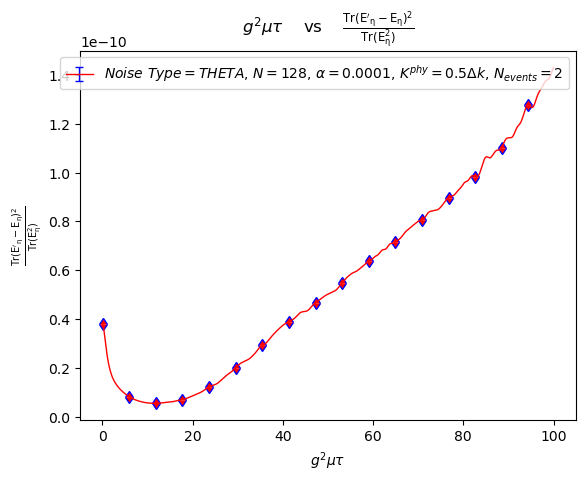

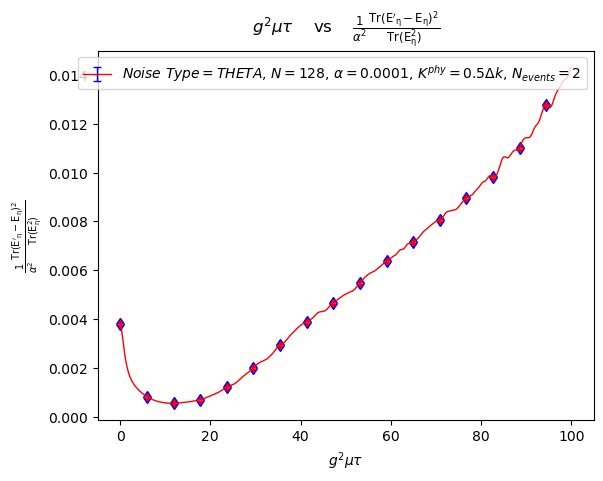

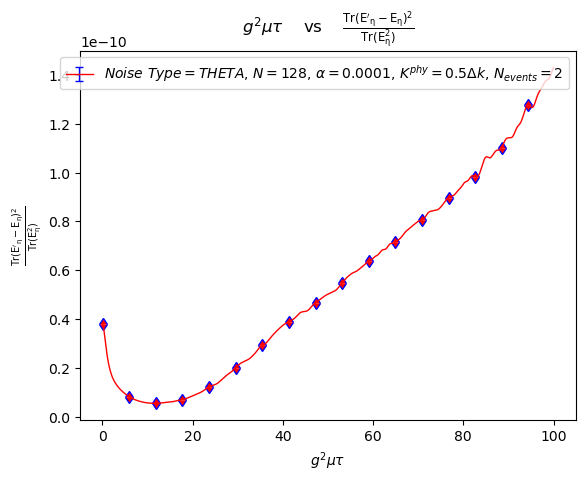

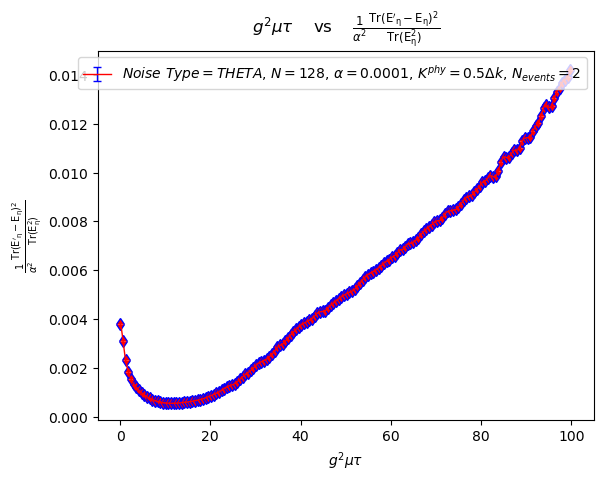

In [3]:
x1 = tau                                                      
y1 = r["ratio_dif"] 
y1_var = r["ratio_dif_variance"]
y1_std = r["ratio_dif_std"]
y1_error = r["ratio_dif_error"]                                 # np.sqrt(y1_var/N_events)    # Calculate the error bars using the variance

x2 = tau
y2 = r["ratio_difalpha2"]
y2_var = r["ratio_difalpha2_variance"]
y2_std = r["ratio_difalpha2_std"]
y2_error = r["ratio_difalpha2_error"]                           # np.sqrt(y2_var/N_events)                                                       

"""
print("\n output[\"ratio_dif_error\"]          = ", r["ratio_dif_error"])
print("\n y1_error        = ", y1_error)

print("\n output[\"ratio_difalpha2_error\"]          = ", r["ratio_difalpha2_error"])
print("\n y2_error        = ", y2_error)
"""

#Plotting here using the data from the dictionary:
if Option_noise_type == 0:
    print("\nNo noise case. Exiting the program.\n")
    label_dynamic = rf"$Noise~Type = {noise_type_str}$, $N = {N}$, $\alpha = {alpha_str}$, $N_{{events}} = {N_events}$"
    sys.exit(1)
if(Option_noise_type == 1):
    label_dynamic = rf"$Noise~Type = {noise_type_str}$, $N = {N}$, $\alpha = {alpha_str}$, $m_{{noise}}^{{phy}} = {mnoise_str}~ g²\mu$, $N_{{events}} = {N_events}$"
elif(Option_noise_type == 2):
    label_dynamic = rf"$Noise~Type = {noise_type_str}$, $N = {N}$, $\alpha = {alpha_str}$, $m_{{noise}}^{{phy}} = {mnoise_str}~ g²\mu$, $N_{{events}} = {N_events}$"
elif(Option_noise_type == 3):
    label_dynamic = rf"$Noise~Type = {noise_type_str}$, $N = {N}$, $\alpha = {alpha_str}$, $K^{{phy}} = {K_str} \Delta k$, $N_{{events}} = {N_events}$"


#label_dynamic = rf"$Noise~Type = {noise_type_str}$, $N = {N}$, $\alpha = {alpha_str}$, $m_{{noise}}^{{phy}} = {mnoise_str}~ g²\mu$, $N_{{events}} = {N_events}$"

plt.errorbar(x1, y1, y1_error,   label=label_dynamic,  errorevery=100,  linewidth=1, linestyle="solid", color="red", ecolor="blue", elinewidth=1,  uplims=True, lolims=True)#, capsize=3, capthick=1)
plt.title(r"$g^2 \mu \tau$    vs    $\mathrm {\frac{Tr(E'_{\eta} - E_{\eta})^2}{Tr(E_{\eta}^2)} }$")            # Plot title
plt.xlabel(r"$g^2 \mu \tau$")
plt.ylabel(r"$\mathrm {\frac{Tr(E'_{\eta} - E_{\eta})^2}{Tr(E_{\eta}^2)} }$")
#plt.xlim(0.0, 200)                                                                                                  # To change the x scale       
#plt.ylim(0.0, 0.00000001)                                                                                           # To change the y scale      
plt.legend()
plt.show()


plt.errorbar(x2, y2, y2_error,   label=label_dynamic,  errorevery=100,  linewidth=1, linestyle="solid", color="red", ecolor="blue", elinewidth=1,  uplims=True, lolims=True)#, capsize=3, capthick=1)
plt.title(r"$g^2 \mu \tau$    vs    $ \frac{1}{\alpha^2} \mathrm {\frac{Tr(E'_{\eta} - E_{\eta})^2}{Tr(E_{\eta}^2)} }$")            # Plot title
plt.xlabel(r"$g^2 \mu \tau$")
plt.ylabel(r"$ \frac{1}{\alpha^2}\mathrm {\frac{Tr(E'_{\eta} - E_{\eta})^2}{Tr(E_{\eta}^2)} }$")
#plt.xlim(0.0, 200)                                                                                                       
#plt.ylim(0.0, 1)                                                                                              
plt.legend()
plt.show()


# Saving data to a CSV file and plotting from file using pandas

# Create a DataFrame
df1 = pd.DataFrame({
    "tau": x1,
    "diff_Eeta": y1,
    "diff_Eeta_variance": y1_var,
    "diff_Eeta_std": y1_std,
    "diff_Eeta_error": y1_error,
    "N_events": N_events,
})

df2 = pd.DataFrame({
    "tau": x2,
    "diff_Eetaalpha2": y2,
    "diff_Eetaalpha2_variance": y2_var,
    "diff_Eetaalpha2_std": y2_std,
    "diff_Eetaalpha2_error": y2_error,
    "N_events": N_events,
})


# ============================================== Generating dynamic file names ==============================================
if Option_noise_type == 0:
    print("\nNo noise case. \n")
    data_filename1 = f"data_tau_diffEeta_Noise{noise_type_str}_N{N}_alpha{alpha_str}_Nevents{N_events}.csv"  
    data_filename2 = f"data_tau_diffEetaalpha2_Noise{noise_type_str}_N{N}_alpha{alpha_str}_Nevents{N_events}.csv"   
    #sys.exit(1)
    	
if(Option_noise_type == 1):
	data_filename1 = f"data_tau_diffEeta_Noise{noise_type_str}_N{N}_alpha{alpha_str}_m{mnoise_str}_Nevents{N_events}.csv"  
	data_filename2 = f"data_tau_diffEetaalpha2_Noise{noise_type_str}_N{N}_alpha{alpha_str}_m{mnoise_str}_Nevents{N_events}.csv"   

elif(Option_noise_type == 2):
	data_filename1 = f"data_tau_diffEeta_Noise{noise_type_str}_N{N}_alpha{alpha_str}_m{mnoise_str}_Nevents{N_events}.csv"   
	data_filename2 = f"data_tau_diffEetaalpha2_Noise{noise_type_str}_N{N}_alpha{alpha_str}_m{mnoise_str}_Nevents{N_events}.csv"   

elif(Option_noise_type == 3):
	data_filename1 = f"data_tau_diffEeta_Noise{noise_type_str}_N{N}_alpha{alpha_str}_K{K_str}_Nevents{N_events}.csv"  
	data_filename2 = f"data_tau_diffEetaalpha2_Noise{noise_type_str}_N{N}_alpha{alpha_str}_K{K_str}_Nevents{N_events}.csv"   

#data_filename1 =       f"data_tau_diffEeta_Noise{noise_type_str}_N{N}_alpha{alpha_str}_m{mnoise_str}_Nevents{N_events}.csv"  
#data_filename2 = f"data_tau_diffEetaalpha2_Noise{noise_type_str}_N{N}_alpha{alpha_str}_m{mnoise_str}_Nevents{N_events}.csv"   
# ===========================================================================================================================

df1.to_csv(data_filename1, index=False)                                                                                 # Save the DataFrame to a CSV file
df1 = pd.read_csv(data_filename1)                                                                                       # Read the CSV file into a DataFrame

plt.errorbar(df1["tau"], df1["diff_Eeta"], df1["diff_Eeta_error"], label=label_dynamic,  errorevery=100,  linewidth=1, linestyle="solid", color="red", ecolor="blue", elinewidth=1,  uplims=True, lolims=True)#, capsize=3, capthick=1)
plt.title(r"$g^2 \mu \tau$    vs    $\mathrm {\frac{Tr(E'_{\eta} - E_{\eta})^2}{Tr(E_{\eta}^2)} }$")            # Plot title
plt.xlabel(r"$g^2 \mu \tau$")
plt.ylabel(r"$\mathrm {\frac{Tr(E'_{\eta} - E_{\eta})^2}{Tr(E_{\eta}^2)} }$")
#plt.xlim(0.0, 200)                                                                                                    
#plt.ylim(0.0, 0.00000001)                                                                                              
plt.legend()
plt.show()


df2.to_csv(data_filename2, index=False)                                                                                
df2 = pd.read_csv(data_filename2)
plt.errorbar(df2["tau"], df2["diff_Eetaalpha2"], df2["diff_Eetaalpha2_error"], label=label_dynamic,  errorevery=10,  linewidth=1, linestyle="solid", color="red", ecolor="blue", elinewidth=1,  uplims=True, lolims=True)#, capsize=3, capthick=1)
plt.title(r"$g^2 \mu \tau$    vs    $ \frac{1}{\alpha^2} \mathrm {\frac{Tr(E'_{\eta} - E_{\eta})^2}{Tr(E_{\eta}^2)} }$")            # Plot title
plt.xlabel(r"$g^2 \mu \tau$")
plt.ylabel(r"$ \frac{1}{\alpha^2}\mathrm {\frac{Tr(E'_{\eta} - E_{\eta})^2}{Tr(E_{\eta}^2)} }$")
#plt.xlim(0.0, 200)                                                                                                  # To change the x scale       
#plt.ylim(0.0, 1)                                                                                           # To change the y scale      
plt.legend()
plt.show()




In [4]:
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! This cell is just to save the data in a file for Lyapunov exponents !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

alpha_str = f"{alpha:.6f}".rstrip('0').rstrip('.')
mnoise_str = f"{Lypnv_noise_scale:.1f}"                         

print("mnoise_str = ", mnoise_str)
print("alpha_str = ", alpha_str)
print("noise_type_str = ", noise_type_str)

text = rf"$Noise type = {Noise_type}$" + "\n" + rf"$N_{{events}} = {N_events}$" + "\n" + rf"$N = {N}$" + "\n\n" + rf"$\alpha = {alpha_str}$" + "\n" + rf"$m_{{noise}}^{{phy}} = {Lypnv_noise_scale} g²\mu$" 


# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #
x1 = tau                                                      
y1 = r["ratio_dif"]    
data_filename1 = f"data_tau_diffEeta_Noise{noise_type_str}_N{N}_alpha{alpha_str}_m{mnoise_str}.csv"             # Dynamically generate file names
df = pd.DataFrame({"tau": x1, "diff_Eeta": y1})                                                                 # Save Data into csv file
df.to_csv(data_filename1, index=False)
#data1 = pd.read_csv(data_filename1)          # Read data from file for plotting
#plt.plot(data1['tau'], data1['diff_Eeta'], 'b-', linewidth=1)                                                  # Basic line plot

x2 = tau                                                                        
y2 = r["ratio_dif"]/alpha2   
data_filename2 = f"data_tau_diffEetabyalpha2_Noise{noise_type_str}_N{N}_alpha{alpha_str}_m{mnoise_str}.csv"
df = pd.DataFrame({"tau": x2, "diff_Eeta_alpha2": y2})
df.to_csv(data_filename2, index=False)
#data2 = pd.read_csv(data_filename2)
#plt.plot(data2['tau'], data2['diff_Eeta_alpha2'], 'b-', linewidth=1)

x3 = tau
y3 = r["ratio_dif_variance"]
data_filename3 = f"data_tau_diffEeta_variance_Noise{noise_type_str}_N{N}_alpha{alpha_str}_m{mnoise_str}.csv"
df = pd.DataFrame({"tau": x3, "diff_Eeta_variance": y3})
df.to_csv(data_filename3, index=False)
#data3 = pd.read_csv(data_filename3)
#plt.plot(data3['tau'], data3['diff_Eeta_variance'], 'b-', linewidth=1)

x4 = tau
y4 = r["ratio_dif_variance"]/alpha2 
data_filename4 = f"data_tau_diffEetabyalpha2_variance_Noise{noise_type_str}_N{N}_alpha{alpha_str}_m{mnoise_str}.csv"
df = pd.DataFrame({"tau": x4, "diff_Eeta_alpha2_variance": y4})
df.to_csv(data_filename4, index=False)
#data4 = pd.read_csv(data_filename4)
#plt.plot(data4['tau'], data4['diff_Eeta_alpha2_variance'], 'b-', linewidth=1)
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #

print("\nHello, this cell is run at", datetime.now().strftime("%d-%m-%Y %H:%M:%S"))


mnoise_str =  1.0
alpha_str =  0.0001
noise_type_str =  THETA

Hello, this cell is run at 11-09-2025 17:36:50



Hello, this cell is run!


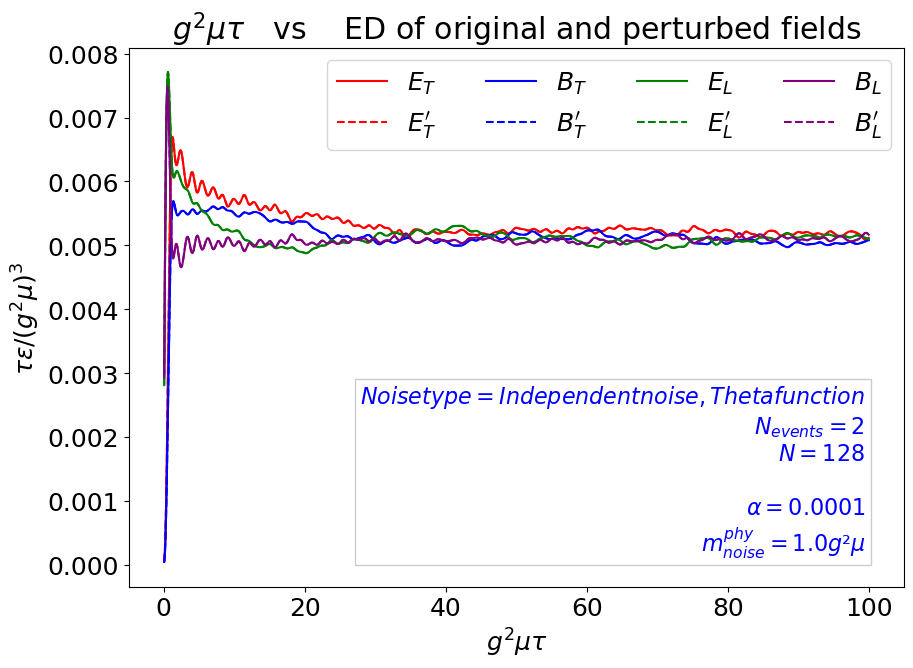

In [5]:
# rc('text', usetex=True)
plt.rcParams["figure.figsize"] = (10, 7)
plt.rcParams.update({'font.size':18})



# plt.plot(tau, np.ones(len(tau)), color='gray')
# plt.errorbar(tau, r["ET"], yerr=r["ET_std"], errorevery=100, label="ET")
# plt.errorbar(tau, r["BT"], yerr=r["BT_std"], errorevery=100, label="BT")
# plt.errorbar(tau, r["EL"], yerr=r["EL_std"], errorevery=100, label="EL")
# plt.errorbar(tau, r["BL"], yerr=r["BL_std"], errorevery=100, label="BL")

colors = ['red', 'blue', 'green', 'purple']

plt.plot(tau, r["ET"], label=r"$E_T$", color=colors[0])
plt.plot(tau, r["ETp"], label=r"$E_T^{\prime}$", linestyle="dashed", color=colors[0])

plt.plot(tau, r["BT"], label=r"$B_T$", color=colors[1])
plt.plot(tau, r["BTp"], label=r"$B_T^{\prime}$", linestyle="dashed", color=colors[1])

plt.plot(tau, r["EL"], label=r"$E_L$", color=colors[2])
plt.plot(tau, r["ELp"], label=r"$E_L^{\prime}$", linestyle="dashed", color=colors[2])

plt.plot(tau, r["BL"], label=r"$B_L$", color=colors[3])
plt.plot(tau, r["BLp"], label=r"$B_L^{\prime}$", linestyle="dashed", color=colors[3])


plt.title(r"$g^2 \mu \tau$   vs    ED of original and perturbed fields")            # Plot title
plt.xlabel(r"$g^2 \mu \tau$")
plt.ylabel(r"$\tau \varepsilon / (g^2 \mu)^3$")


# Construct the LaTeX string using f-strings                    # Add the text to the plot
#text = rf"$N_{{events}} = {N_events}$" + "\n" + rf"$N = {N}$" + "\n\n" + rf"$\alpha = {alpha}$" + "\n" + rf"$m_{{noise}} = {Lypnv_noise_scale} g²\mu ~ GeV$" 
#text = rf"$N_{events} = {N_events}$" + "\n" + rf"$N = {N}$" + "\n" + rf"$\alpha = {alpha}$" + "\n" + rf"$m_{noise} = {m_noise}$" 
#text = rf"$Nevents = {N_events}$" + "\n" + rf"$\alpha = {alpha}$" + "\n" + rf"$N = {N}$"
# text = rf"$N_{{events}} = {N_events}$" + "\n" + rf"$N = {N}$" + "\n\n" + rf"$\alpha = {alpha}$" + "\n" + rf"$m_{{noise}}^{{phy}} = {Lypnv_noise_scale} g²\mu$" 

#text = rf"$Noise type = {Noise_type}$" + "\n" + rf"$N_{{events}} = {N_events}$" + "\n" + rf"$N = {N}$" + "\n\n" + rf"$\alpha = {alpha_str}$" + "\n" + rf"$m_{{noise}}^{{phy}} = {Lypnv_noise_scale} g²\mu$" 

#text = rf"$N_{{events}} = {N_events}$" + "\n" + rf"$N = {N}$" + "\n\n" + rf"$\alpha = {alpha}$" + "\n" + rf"$m_{{noise}}^{{phy}} = {Lypnv_noise_scale} g²\mu$" 

plt.text(0.95, 0.05, text, color="blue", fontsize=16, bbox=dict(facecolor='white', alpha=0.2), transform=plt.gca().transAxes, ha='right', va='bottom')

#plt.text(400, 0.0001, f"N = {N}", fontsize=12, bbox=dict(facecolor='gray', alpha=0.2))               # Add text inside a box         
#plt.text(400, 0.0001, text, color="blue", fontsize=16)


plt.legend(ncols=4)


#plt.savefig('plot_tau_EnergyDensities.png', dpi=600)
#plt.show()

print("\nHello, this cell is run!")



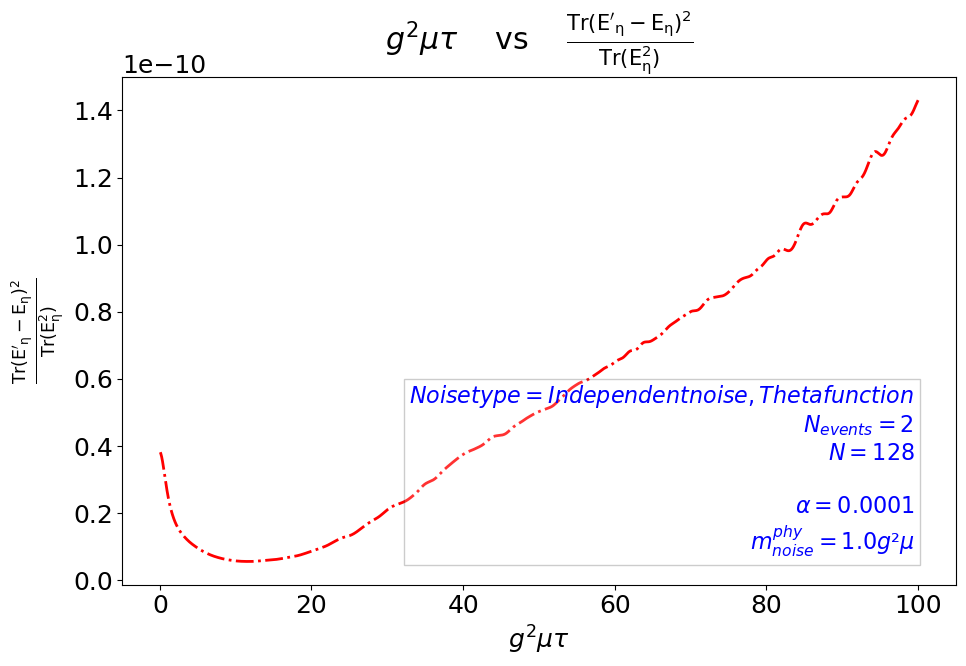

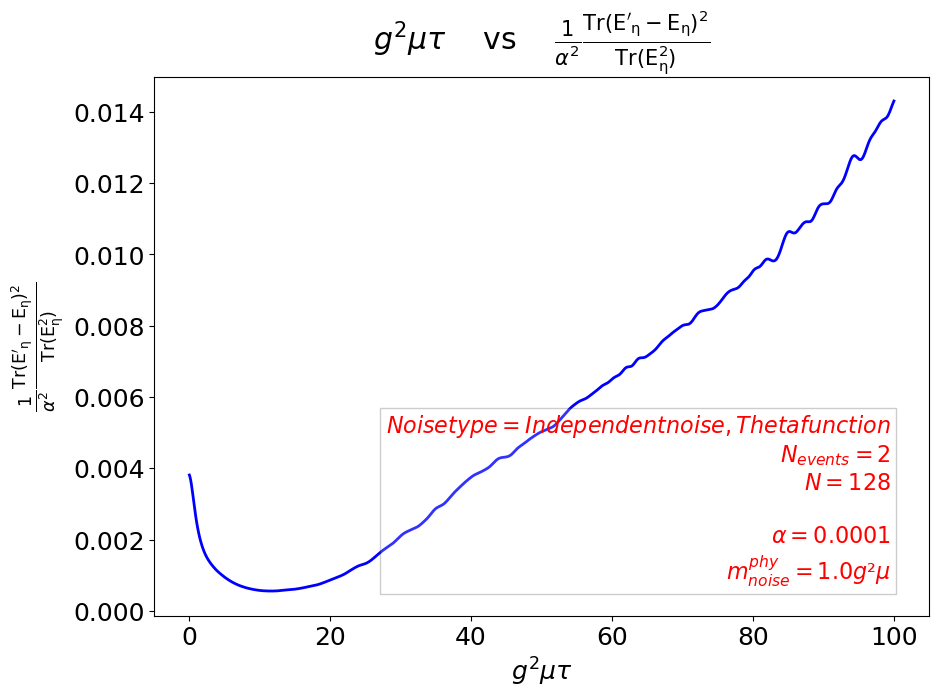


Hello, this cell is run!


In [6]:

# ====================================================================================================================================== #
# Plotting and saving (plot and data) for x for time vs Ratio_difference_Eta



x1 = tau                                                      
y1 = r["ratio_dif"]                                        
plt.plot(x1, y1, color='red', linestyle="dashdot", linewidth=2.0) 

plt.title(r"$g^2 \mu \tau$    vs    $\mathrm {\frac{Tr(E'_{\eta} - E_{\eta})^2}{Tr(E_{\eta}^2)} }$")            # Plot title
plt.xlabel(r"$g^2 \mu \tau$")
plt.ylabel(r"$\mathrm {\frac{Tr(E'_{\eta} - E_{\eta})^2}{Tr(E_{\eta}^2)} }$")
#plt.xlim(0.0, 200)                                                                                              # To change the x scale          
#plt.ylim(0.0, 0.00001)                                                                                        # To change the y scale          


plt.text(0.95, 0.05, text, color="blue", fontsize=16, bbox=dict(facecolor='white', alpha=0.2), transform=plt.gca().transAxes, ha='right', va='bottom')
plt.tight_layout()                                                                                      # Pooja: Automatically adjusts the layout to prevent cutting


# === Dynamically generate file names ===
plot_filename1 = f"plot_tau_diffEeta_Noise{noise_type_str}_N{N}_alpha{alpha_str}_m{mnoise_str}.png"
data_filename1 = f"data_tau_diffEeta_Noise{noise_type_str}_N{N}_alpha{alpha_str}_m{mnoise_str}.csv"           # Dynamically generate file names


# Save plot and data
# plt.savefig('plot_tau_diffEeta.png', dpi=600)
plt.savefig(plot_filename1, dpi=600)
plt.show()

# Save Data into csv file:

#df = pd.DataFrame({"tau": x1, "diff_Eeta": y1})
#df.to_csv(data_filename, index=False)
#df = pd.DataFrame({"tau": x1, "diff_Eeta": y1})                   # Assuming x and y are lists or NumPy arrays
#df.to_csv("data_tau_diffEeta.csv", index=False)


# ====================================================================================================================================== #
# ====================================================================================================================================== #




# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #
# Plotting and saving (plot and data) for x for time vs Ratio_differece_Eta by alpha_squared
x2 = tau                                                                        
y2 = r["ratio_dif"]/alpha2 

                                           
plt.plot(x2, y2, color='blue', linestyle="solid", linewidth=2.0)    

plt.title(r"$g^2 \mu \tau$    vs    $ \frac{1}{\alpha^2} \mathrm {\frac{Tr(E'_{\eta} - E_{\eta})^2}{Tr(E_{\eta}^2)} }$")            # Plot title
plt.xlabel(r"$g^2 \mu \tau$")
plt.ylabel(r"$ \frac{1}{\alpha^2}\mathrm {\frac{Tr(E'_{\eta} - E_{\eta})^2}{Tr(E_{\eta}^2)} }$")
#plt.xlim(0.0, 200)                                                                                        # To change the x scale       
#plt.ylim(0.0, 0.1)                                                                                        # To change the scale          


plt.text(0.95, 0.05, text, color="red", fontsize=16, bbox=dict(facecolor='white', alpha=0.2), transform=plt.gca().transAxes, ha='right', va='bottom')


#plt.savefig('plot_tau_diffEeta_alpha2.png', dpi=600)
#plt.show()

#df = pd.DataFrame({"tau": x2, "diff_Eeta_alpha2": y2})           # Assuming x and y are lists or NumPy arrays
#df.to_csv("data_tau_diffEeta_alpha2.csv", index=False)



# === Dynamically generate file names ===
plot_filename2 = f"plot_tau_diffEetabyalpha2_Noise{noise_type_str}_N{N}_alpha{alpha_str}_m{mnoise_str}.png"
data_filename2 = f"data_tau_diffEetabyalpha2_Noise{noise_type_str}_N{N}_alpha{alpha_str}_m{mnoise_str}.csv"           # Dynamically generate file names


# Save plot and data
plt.savefig(plot_filename2, dpi=600)
plt.show()

#df = pd.DataFrame({"tau": x2, "diff_Eeta_alpha2": y2})
#df.to_csv(data_filename2, index=False)

# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #

print("\nHello, this cell is run!")
